# CP-PINN Final Code

## Generating Training Data using Numerical Solution for the PDE

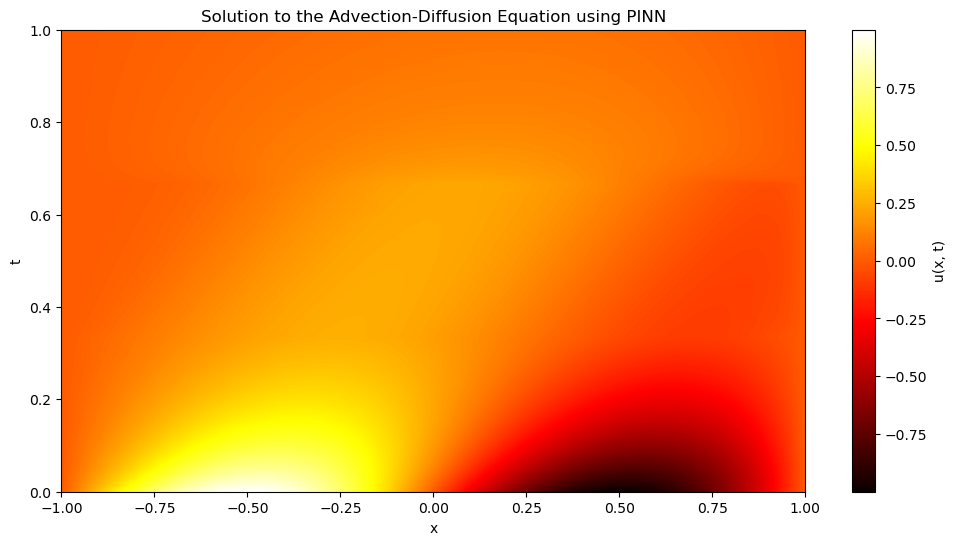

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Ensure that animations display properly in the notebook
%matplotlib inline

# Define spatial parameters
x_min = -1.0
x_max = 1.0
Nx = 1024          # Spatial resolution
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Advection speed
c = 1.0

# Adjust dt based on CFL condition for advection
dt_max = dx / c
dt = dt_max * 0.5  # Use 50% of the maximum allowable dt for stability

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1

# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# New initial condition: u(t=0, x) = -sin(π x)
u0 = -np.sin(np.pi * x)
u_total[0, :] = u0

# Boundary conditions (already satisfied by the initial condition)
u_total[:, 0] = 0.0     # u(-1, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Function to solve the PDE over a given interval using Thomas Algorithm
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n, dt_interval):
    dt = dt_interval
    CFL_advection = c * dt / dx
    if CFL_advection > 1.0:
        print(f"Warning: CFL condition for advection not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1, dt1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
u_initial2 = u_interval1[-1, :] #Initial condition for second interval is the final time configuration of the first interval solution
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2, dt2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3, dt3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3
'''
# Prepare the data for animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Spatial Coordinate x')
ax.set_ylabel('u(x, t)')
ax.set_title('Evolution of u(x, t) Over Time')

# Initialize function for animation
def init():
    line.set_data([], [])
    return line,

# Animation function
def animate(i):
    y = u_total[i, :]
    line.set_data(x, y)
    ax.set_title(f'Evolution of u(x, t) at t = {t[i]:.3f}')
    return line,

# Create the animation
frame_interval = 1  # Adjust this to control the speed of the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt_combined, interval=frame_interval, blit=True)

# Display the animation in the notebook
HTML(anim.to_jshtml())
'''
plt.figure(figsize=(12, 6))
plt.imshow(u_total, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

## Loading the data into batches using Dataloader and Dataset

In [103]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Parameters
learning_rate = 0.0001
eta = learning_rate
num_epochs = 30000

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the domain for x and t
x_values = np.linspace(-1, 1, Nx)
t_values = np.linspace(0, 1, Nt_combined)
X, T = np.meshgrid(x_values, t_values)
x_t_grid = torch.tensor(np.c_[X.ravel(), T.ravel()], dtype=torch.float32).to(device)
# Get the total number of x values in each t slice (201 in your case)
num_x_values = x_values.shape[0] #201
N_total = Nx*Nt_combined
# Extract the first occurrence of each time value by taking a slice with step `num_x_values`
t_grid = x_t_grid[::num_x_values, 1]
t_grid = t_grid.unsqueeze(1)

#Defining Spatial Batches
Batches = []
for i in range(Nx):
    # Find indices in x_t_grid corresponding to the i-th x point
    indices = (x_t_grid[:, 0] == x_values[i])
    # Select all (x, t) points for the current x value
    Batch = x_t_grid[indices]
    Batches.append(Batch)

from torch.utils.data import Dataset

class GridDataset(Dataset):
    def __init__(self, x_t_grid, x_values, u_total):
        
        self.x_t_grid = x_t_grid
        self.x_values = x_values
        self.u_total = u_total

    def __len__(self):
        
        return len(self.x_values)

    def __getitem__(self, idx):
    
        x_value = self.x_values[idx]
        indices = (self.x_t_grid[:, 0] == x_value)
        batch = self.x_t_grid[indices]
        u_values = self.u_total[:,idx]
        
        # Convert to torch tensors
        u_values_tensor = torch.tensor(u_values, dtype=torch.float32,device=device)
        
        return batch, u_values_tensor

# Create dataset and dataloader
grid_dataset = GridDataset(x_t_grid, x_values,u_total)
dataloader = DataLoader(grid_dataset, batch_size=1024, shuffle=True)

Using device: cuda


# Creating the neural network architecture

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
b=10.0
class GELU_PINN(nn.Module):
    def __init__(self):
        super(GELU_PINN, self).__init__()  # Corrected class name
        
        # Network for u(x, t)
        self.fc1_u = nn.Linear(2, 20)
        self.fc2_u = nn.Linear(20, 20)
        self.fc3_u = nn.Linear(20, 20)
        self.fc4_u = nn.Linear(20, 20)
        self.fc5_u = nn.Linear(20, 20)
        self.fc6_u = nn.Linear(20, 20)
        self.fc7_u = nn.Linear(20, 20)
        self.fc8_u = nn.Linear(20, 20)
        self.fc9_u = nn.Linear(20, 1)
        
    def forward(self, x):
        # Predict u(x, t) using the full (x, t) input
        # Using tanh activation functions
        u = F.tanh(self.fc1_u(x))
        u = F.tanh(self.fc2_u(u))
        u = F.tanh(self.fc3_u(u))
        u = F.tanh(self.fc4_u(u))
        u = F.tanh(self.fc5_u(u))
        u = F.tanh(self.fc6_u(u))
        u = F.tanh(self.fc7_u(u))
        u = F.tanh(self.fc8_u(u))
        u = self.fc9_u(u)        
        return u

# Create the updated model
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_updated = GELU_PINN().to(device)


# Apply Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Optionally, initialize biases to zero

model_updated.apply(init_weights)

# Verify initialization
#for name, param in model_updated.named_parameters():
#    print(f"{name}: {param.data}")

GELU_PINN(
  (fc1_u): Linear(in_features=2, out_features=20, bias=True)
  (fc2_u): Linear(in_features=20, out_features=20, bias=True)
  (fc3_u): Linear(in_features=20, out_features=20, bias=True)
  (fc4_u): Linear(in_features=20, out_features=20, bias=True)
  (fc5_u): Linear(in_features=20, out_features=20, bias=True)
  (fc6_u): Linear(in_features=20, out_features=20, bias=True)
  (fc7_u): Linear(in_features=20, out_features=20, bias=True)
  (fc8_u): Linear(in_features=20, out_features=20, bias=True)
  (fc9_u): Linear(in_features=20, out_features=1, bias=True)
)

In [5]:
# Load the checkpoint from a pretrained model
checkpoint = torch.load("tanh_pinn_model_training_data9.pth")

# Restore the weights into the updated model
model_updated.load_state_dict(checkpoint['model_state_dict'])

# Restore optimizer and training state
optimizer = optim.Adam(list(model_updated.parameters()), lr=1e-3)  # Replace `1e-3` with your learning rate
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
last_loss = checkpoint['loss']  # Last loss value

print(f"Checkpoint loaded into updated model. Resuming training from epoch {start_epoch}. Last loss: {last_loss}")

C:\Users\yaman\AppData\Local\Temp\ipykernel_15748\3314319886.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("tanh_pinn_model_training_data9.pth"

Checkpoint loaded into updated model. Resuming training from epoch 3000. Last loss: 0.014259065501391888


# Optimizer and training algorithm for training the neural network from the training data.

In [8]:
learning_rate = 0.0001
eta = learning_rate
optimizer = optim.Adam(list(model_updated.parameters()), lr=eta)

In [9]:
def training_loss(model,batch):
    x_t = batch[0]
    u_pred = model(x_t)[:,:,0]
    u_train = batch[1]
    return torch.sum((u_pred - u_train)**2)

In [47]:
for epoch in range(10):
    
    loss_train = 0
    for index, batch in enumerate(dataloader):
        
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        L_train = training_loss(model_updated,batch)
                
        optimizer.zero_grad()
        L_total = L_train
        loss_train += L_train
        
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        
    if epoch%1==0:
        print(f"epochs:{epoch+1} , Loss:{loss_train}")

epochs:1 , Loss:0.014286836609244347
epochs:2 , Loss:0.014287819154560566
epochs:3 , Loss:0.014292288571596146
epochs:4 , Loss:0.014291663654148579
epochs:5 , Loss:0.014296572655439377
epochs:6 , Loss:0.014291280880570412
epochs:7 , Loss:0.014287368394434452
epochs:8 , Loss:0.014280900359153748
epochs:9 , Loss:0.014290114864706993
epochs:10 , Loss:0.014297433197498322


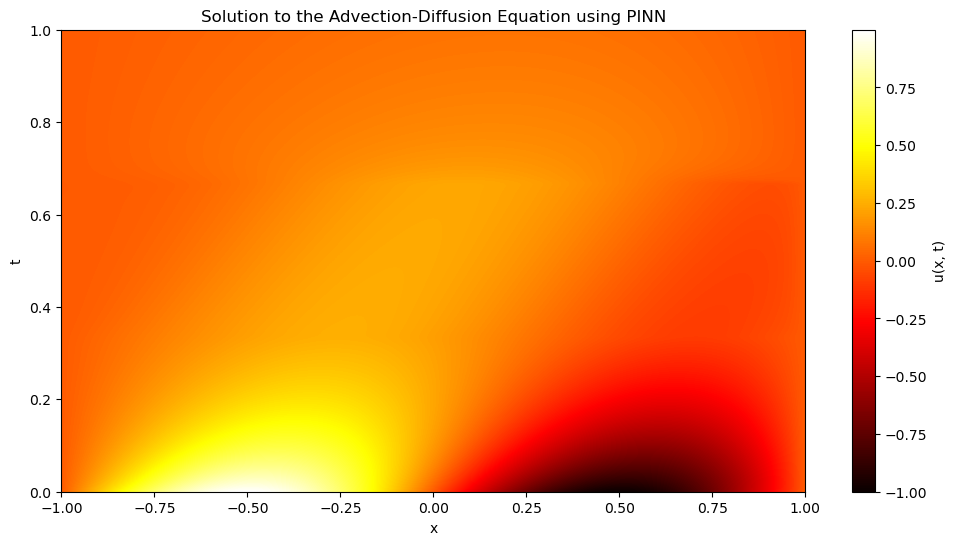

In [11]:
# Plotting the neural network solution from the trained network.
tensor = model_updated(x_t_grid).reshape(1024,1024)

# Convert the tensor to a NumPy array
tensor_np = tensor.detach().cpu().numpy()
u_pred = tensor_np #u_pred is the output of the neural network (converted to numpy array)
plt.figure(figsize=(12, 6))
plt.imshow(u_pred, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

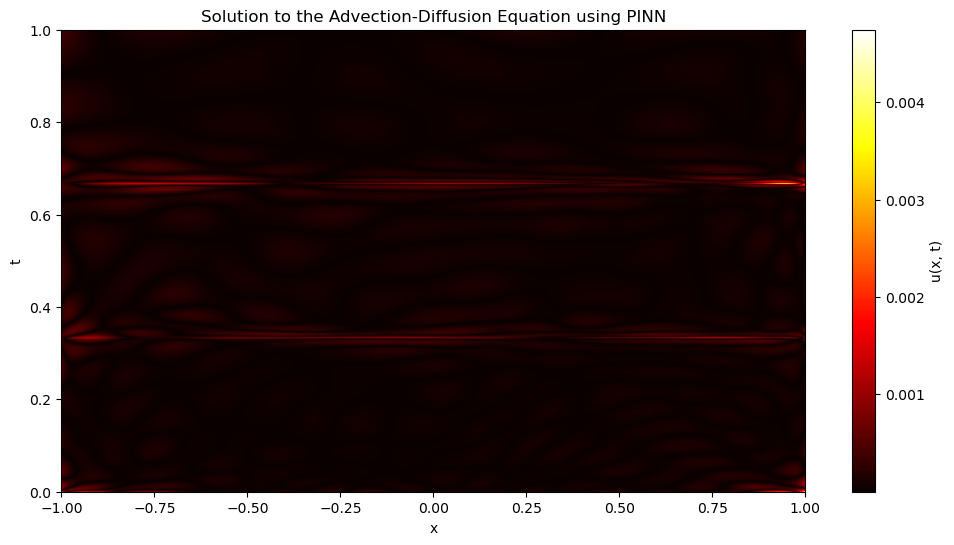

In [13]:
#Plotting the absolute difference between the trained network output and the training data.
plt.figure(figsize=(12, 6))
plt.imshow(abs(u_total-u_pred), extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

# The time derivative could give us an indication for the change points

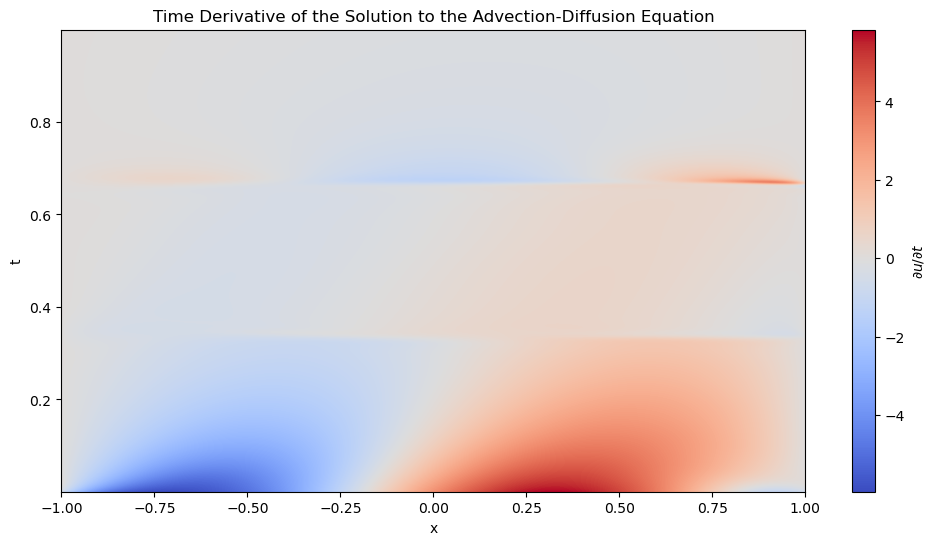

In [15]:
# Calculate the time derivative of u_pred which is the output of the neural network.
du_pred_dt = np.diff(u_pred, axis=0) / dt  # Central difference in time

# Prepare the time vector for the derivative (midpoints between original time steps)
t_derivative = 0.5 * (t[:-1] + t[1:])

# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_pred_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()

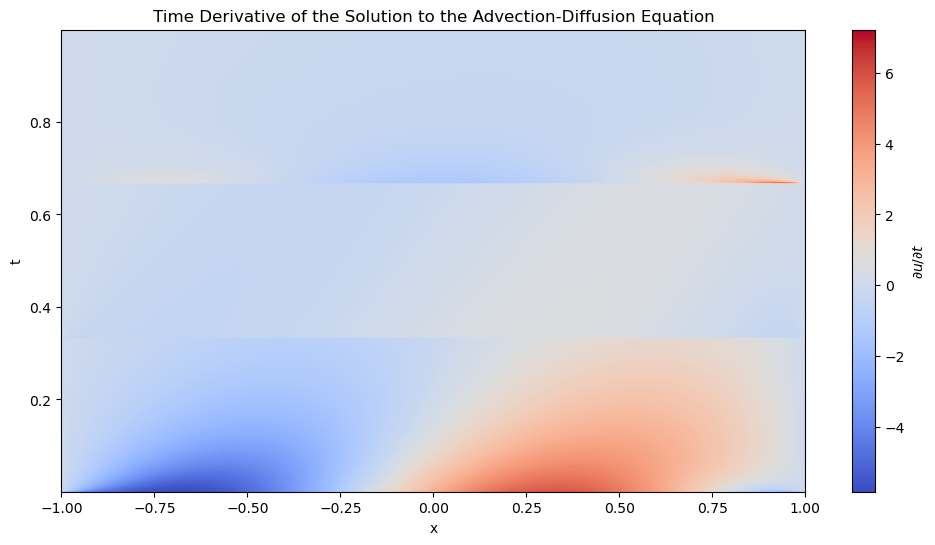

In [17]:
# Calculate the time derivative of u_total which is the actual training data
du_total_dt = np.diff(u_total, axis=0) / dt  # Central difference in time

# Prepare the time vector for the derivative (midpoints between original time steps)
t_derivative = 0.5 * (t[:-1] + t[1:])

# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_total_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()

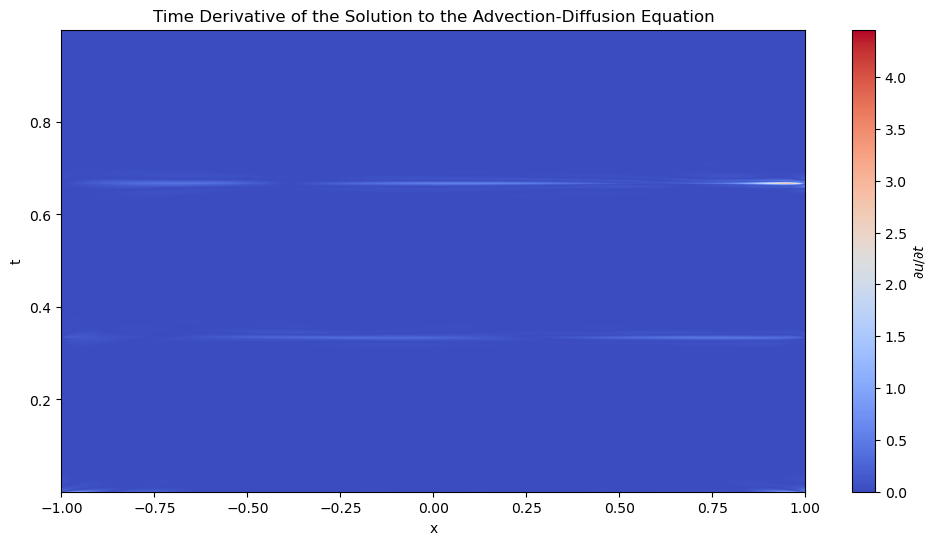

In [19]:
# Plot the difference in the time derivative of u_total and u_pred
plt.figure(figsize=(12, 6))
plt.imshow(
    abs(du_total_dt-du_pred_dt),
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()

# Training lambdas from the trained model using linear regression: u_x + u_t = lambda(t) u_xx

In [21]:
u_pred = model_updated(x_t_grid.reshape(1024,1024,2))
u_pred = u_pred[:,:,0]

In [23]:
x_t = x_t_grid.reshape(1024,1024,2)
X_val = x_t[0].clone()
X_val.requires_grad = True
u_pred = model_updated(X_val)
u_pred = u_pred[:,0]
grads = torch.autograd.grad(u_pred, X_val, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
u_pred_x = grads[:,0]
u_pred_t = grads[:,1]

u_pred_grads = torch.autograd.grad(u_pred_x, X_val, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
u_pred_xx = u_pred_grads[:,0]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
Lambda = []
for i in range(Nt_combined):
    X_val = x_t[i].clone()
    X_val.requires_grad = True
    u_pred = model_updated(X_val)
    u_pred = u_pred[:,0]
    grads = torch.autograd.grad(u_pred, X_val, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_pred_x = grads[:,0]
    u_pred_t = grads[:,1]

    u_pred_grads = torch.autograd.grad(u_pred_x, X_val, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_pred_xx = u_pred_grads[:,0]
    Y_train = u_pred_x.detach().cpu().numpy() + u_pred_t.detach().cpu().numpy()
    Y_train = Y_train.reshape(Nx,1)
    X_train = u_pred_xx.detach().cpu().numpy()
    X_train = X_train.reshape(Nx,1)

    model = LinearRegression(fit_intercept=False)

    # Train the model
    model.fit(X_train, Y_train)
    Lambda.append(model.coef_.item())

In [26]:
len(Lambda)
len(t)

1024

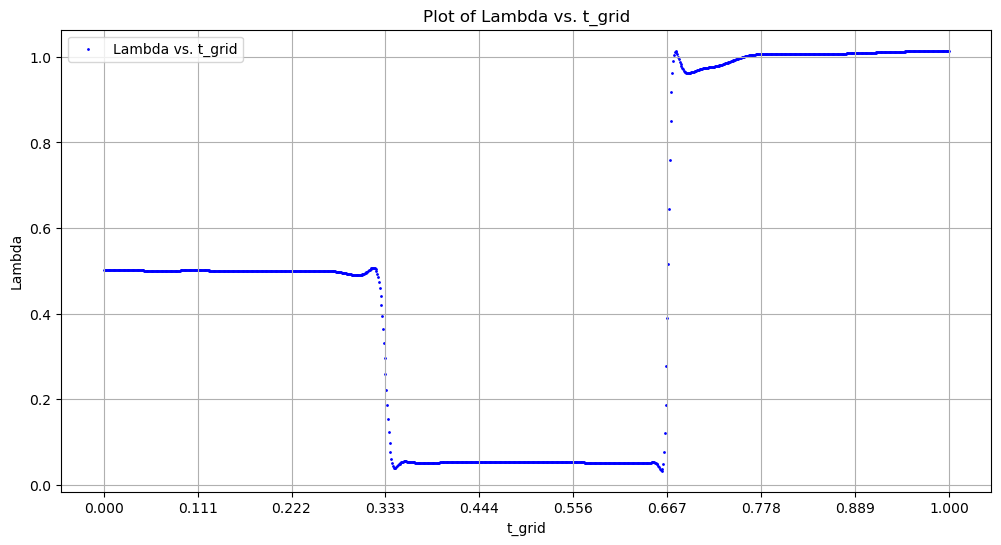

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Lambda and t_grid are already defined
# Example initialization (if needed):
# Lambda = np.random.rand(1024)
# t_grid = np.linspace(0, 1, 1024)

plt.figure(figsize=(12, 6))
plt.scatter(t, Lambda, label="Lambda vs. t_grid", color='b', s=1)

# Method 1: Specify the number of ticks you want
plt.xticks(np.linspace(min(t), max(t), 10))  # Shows 20 evenly spaced ticks

# Alternative Method 2: Set tick locations with specific intervals
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.05))  # Shows ticks every 0.05 units

plt.xlabel("t_grid")
plt.ylabel("Lambda")
plt.title("Plot of Lambda vs. t_grid")
plt.grid(True)
plt.legend()
plt.show()

We will use the trained neural network weights and the lambda values as initial parameters for the CP PINN training.

In [33]:
lambda_param = nn.Parameter(torch.tensor(Lambda, dtype=torch.float32, requires_grad=True, device=device))

In [87]:
# Compute the physics-informed loss
def physics_informed_loss(model, x_t):
    x_t.requires_grad = True
    u = model_updated(x_t)
    u = u[:,:,0]
    # Compute gradients for ∂u/∂t and ∂u/∂x
    grads = torch.autograd.grad(u, x_t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,:, 1]
    u_x = grads[:,:, 0]
    
    # Compute the second derivative ∂²u/∂x²
    u_x_grad = torch.autograd.grad(u_x, x_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xx = u_x_grad[:,:, 0]

    #u_xx_trans = u_xx.t()
    diffusion = lambda_param*u_xx
    #diffusion = diffusion.t()
    advection_diffusion_loss = u_t + u_x - diffusion

    return torch.sum(advection_diffusion_loss**2)

In [121]:
import numpy as np
# The following is the weight function that we will use to weight the gradients of the lambda.
def weight_function(t):
    """
    Defines a function such that:
    - For 0 < t < 1/2: f(t) = 9 * (t - 1/3)^2
    - For 1/2 < t < 1: f(t) = 9 * (t - 2/3)^2
    """
    result = np.zeros_like(t)
    
    # Apply the first condition: 0 < t < 1/2
    mask1 = ((t >= 0) & (t <= 0.32)) | ((t>=0.34) & (t<=0.65)) | ((t>=0.675) & (t<=1.0))
    result[mask1] = 1000

    # Apply the second condition: 1/2 < t < 1
    mask2 = ((t > 0.32) & (t < 0.34)) | ((t>0.660) & (t<0.675))
    result[mask2] = 0

    return result


# Compute the piecewise function
f2_t = weight_function(t)

In [135]:
import torch
import numpy as np

def lambda_loss(lambda_param, t):
    
    # Verify inputs have the same length
    if len(lambda_param) != len(t):
        raise ValueError("lambda_param and t must have the same length")
    
    # Compute f_t weights
    f2_t = weight_function(t)
    f2_t_tensor = torch.tensor(f2_t, dtype=lambda_param.dtype).to(device)
    
    # Compute differences between consecutive elements
    lambda_diff = lambda_param[1:] - lambda_param[:-1]
    
    # Square the differences
    lambda_diff_squared = lambda_diff ** 2
    
    # Use f_t as weights (excluding the last point since we have n-1 differences)
    weighted_sum = torch.sum(f2_t_tensor[:-1] * lambda_diff_squared)
    
    return (1000*weighted_sum)

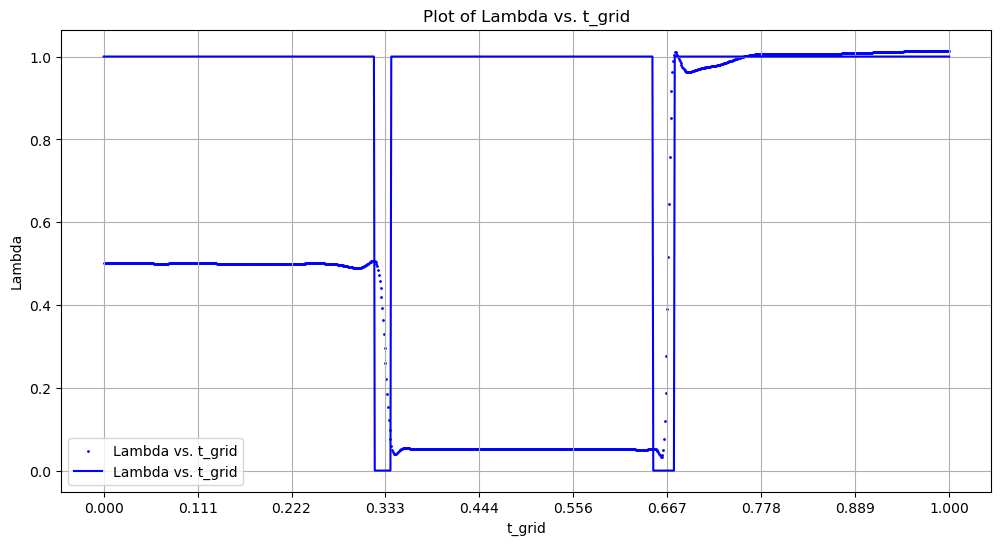

In [129]:
# The following shows the weight function for lambda's gradients and pre-trained lambda simultaneously.
import matplotlib.pyplot as plt
import numpy as np
lambda_plot = lambda_param.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.scatter(t, lambda_plot, label="Lambda vs. t_grid", color='b', s=1)
plt.plot(t,(1/1000)*f2_t, label="Lambda vs. t_grid", color='b')

# Method 1: Specify the number of ticks you want
plt.xticks(np.linspace(min(t), max(t), 10))  # Shows 20 evenly spaced ticks

plt.xlabel("t_grid")
plt.ylabel("Lambda")
plt.title("Plot of Lambda vs. t_grid")
plt.grid(True)
plt.legend()
plt.show()

In [131]:
torch.save(lambda_param, "lambda.pt")

In [133]:
# Move the tensor to the CPU and detach it to avoid gradient tracking
cpu_tensor = lambda_param.detach().cpu()

# Convert the detached tensor to a NumPy array
numpy_array = cpu_tensor.numpy()

# Save the NumPy array to a file (e.g., .npy format)
np.save("lambda.npy", numpy_array)

In [ ]:
#Final Training Loop

In [139]:
def training_loss(model,batch):
    x_t = batch[0]
    u_pred = model(x_t)[:,:,0]
    u_train = batch[1]
    return torch.sum((u_pred - u_train)**2)

In [141]:
# Updating weights for the batches.
def update_weights(L_pinn, L_train, L_lambda):    
    # Compute weights using torch.exp
    W1 = torch.exp(-eta * L_pinn)
    W2 = torch.exp(-eta * L_train)
    W3 = torch.exp(-eta * L_lambda)
    
    # Normalize weights to sum to 1
    S = W1 + W2 + W3
    W1 = W1 / S
    W2 = W2 / S
    W3 = W3 / S
    
    # Convert weights to scalar values for further use
    return W1, W2, W3

In [143]:
optimizer = optim.Adam(list(model_updated.parameters()) + [lambda_param], lr=0.0001)

In [ ]:
w1 = torch.tensor(1/3, dtype=torch.float32, device=device)
w2 = torch.tensor(1/3, dtype=torch.float32, device=device)
w3 = torch.tensor(1/3, dtype=torch.float32, device=device)

In [157]:
# Final Training loop for CP-PINNs
num_epochs = 30000
for epoch in range(num_epochs):
    loss = 0
    loss_pinn = 0
    loss_train = 0
    loss_lambda= 0
    for index, batch in enumerate(dataloader):
        
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        L_pinn = physics_informed_loss(model_updated,x_t_batch)
        L_train = training_loss(model_updated,batch)
        L_lambda = lambda_loss(lambda_param,t)
        
        #L_total = L_pinn + L_train + L_lambda
        
        optimizer.zero_grad()
    
        # Step 2: Compute the total loss
        L_total = w1*L_pinn + w2*L_train + w3*L_lambda
        loss += L_total
        loss_pinn += L_pinn
        loss_train += L_train
        loss_lambda += L_lambda
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        w1, w2, w3 = update_weights(L_pinn.detach(), L_train.detach(), L_lambda.detach())
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{loss}, Losses:{loss_pinn.item(),loss_train.item(),loss_lambda.item()}, Weights:{w1.item(),w2.item(),w3.item()}")
    #if epoch%1000==0:
    #    print(f"lambda:{lambda_param}")

epochs:100 , Loss:122.03621673583984, Losses:(325.7017822265625, 30.070384979248047, 16.4226016998291), Weights:(0.32664626836776733, 0.3364471197128296, 0.3369066119194031)
epochs:200 , Loss:99.9075698852539, Losses:(274.93194580078125, 22.557485580444336, 6.7491631507873535), Weights:(0.32757461071014404, 0.3359469473361969, 0.33647847175598145)
epochs:300 , Loss:85.4821548461914, Losses:(236.96917724609375, 18.506790161132812, 4.363498687744141), Weights:(0.3283403813838959, 0.3355923295021057, 0.3360673189163208)
epochs:400 , Loss:74.91767883300781, Losses:(207.51568603515625, 16.1180419921875, 3.7246253490448), Weights:(0.32895684242248535, 0.3353136479854584, 0.3357294797897339)
epochs:500 , Loss:66.6666488647461, Losses:(184.08197021484375, 14.549269676208496, 3.4153292179107666), Weights:(0.32945361733436584, 0.33508652448654175, 0.33545982837677)
epochs:600 , Loss:60.281673431396484, Losses:(165.8358154296875, 13.453369140625, 3.2122080326080322), Weights:(0.3298424780368805, 

KeyboardInterrupt: 

Plotting the solutions:

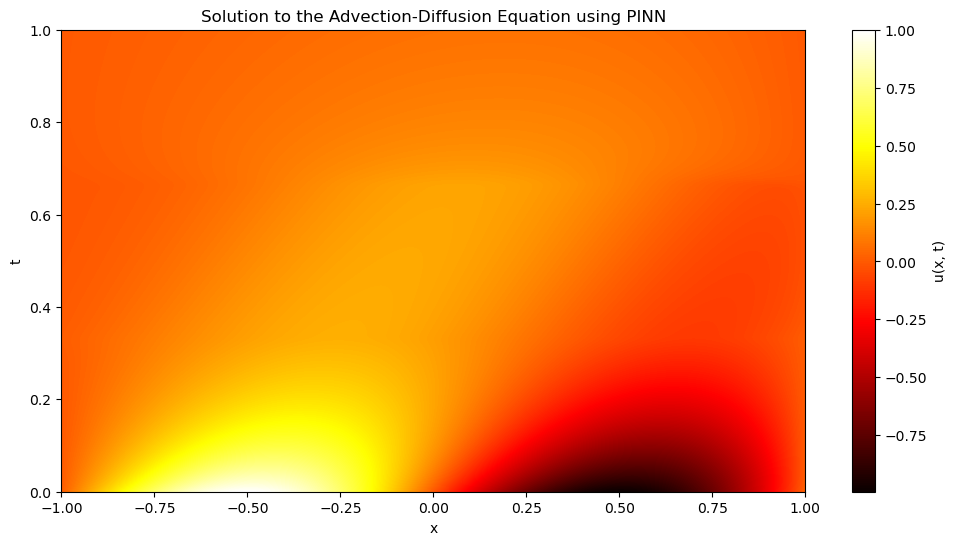

In [159]:
tensor = model_updated(x_t_grid).reshape(1024,1024)

# Convert the tensor to a NumPy array
tensor_np = tensor.detach().cpu().numpy()
u_pred = tensor_np
plt.figure(figsize=(12, 6))
plt.imshow(u_pred, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

Plotting the absolute error

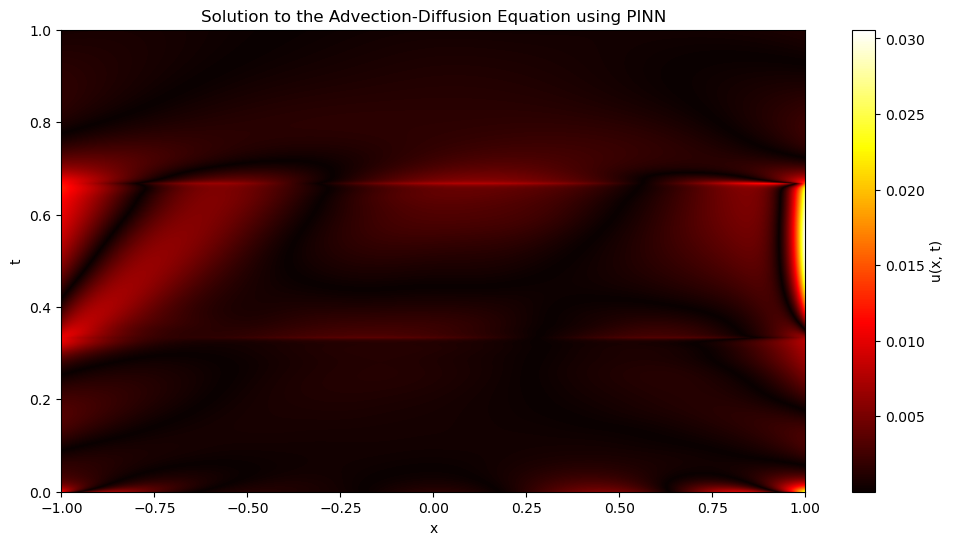

In [161]:
plt.figure(figsize=(12, 6))
plt.imshow(abs(u_pred-u_total), extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

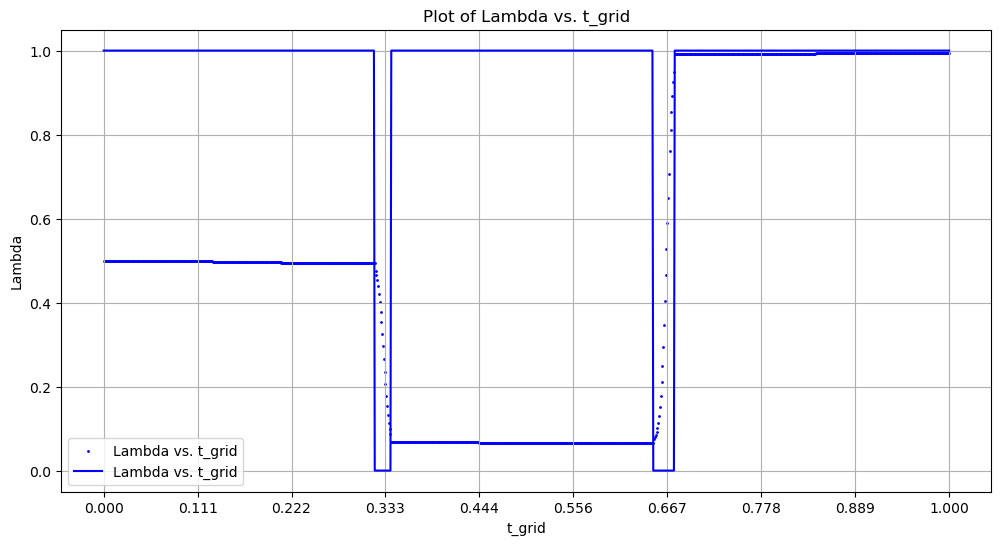

In [173]:
# Plotting the weight function along with CP-PINN trained lambda.
import matplotlib.pyplot as plt
import numpy as np
lambda_plot = lambda_param.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.scatter(t, lambda_plot, label="Lambda vs. t_grid", color='b', s=1)
plt.plot(t,(1/1000)*f2_t, label="Lambda vs. t_grid", color='b')

# Method 1: Specify the number of ticks you want
plt.xticks(np.linspace(min(t), max(t), 10))  # Shows 20 evenly spaced ticks

plt.xlabel("t_grid")
plt.ylabel("Lambda")
plt.title("Plot of Lambda vs. t_grid")
plt.grid(True)
plt.legend()
plt.show()

In [169]:
save_path = "model_and_params_good.pth"

# Save model state, optimizer state, and lambda_param
torch.save({
    'model_state_dict': model_updated.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lambda_param': lambda_param  # Save the entire tensor array
}, save_path)

print(f"Training parameters saved to {save_path}")


Training parameters saved to model_and_params_good.pth


In [177]:
print(lambda_plot)

[0.4983851  0.49839765 0.4984182  ... 0.994414   0.9944136  0.9944143 ]


In [183]:
t[330]

0.3225806451612903

In [207]:
lambda_plot[328]

0.4936593

In [211]:
np.std(lambda_plot[:328], axis=None, ddof=0, keepdims=False)

0.0016178418

In [229]:
lambda_plot[691]

0.9918923

In [231]:
np.std(lambda_plot[691:], axis=None, ddof=0, keepdims=False)

0.00072421064

In [251]:
np.std(lambda_plot[350:650], axis=None, ddof=0, keepdims=False)

0.001176344